## When Deep Learning Met Code Search

https://arxiv.org/pdf/1905.03813.pdf

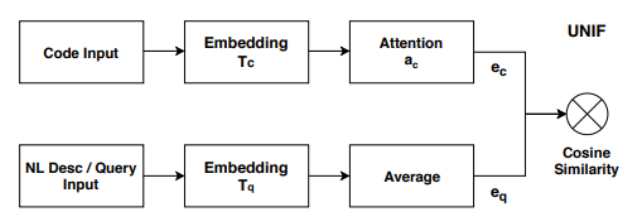

In [29]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import random
import numpy as np
import tables
from tqdm import tqdm

## Dataset

In [30]:
def read_file(path):
    file = open(path, 'r')
    return file.read()

The dataset from [Deep code search](https://dl.acm.org/doi/10.1145/3180155.3180167) repository ([link](https://github.com/guxd/deep-code-search)) comes in h5 format and should be dowloaded from [drive](https://drive.google.com/drive/folders/1GZYLT_lzhlVczXjD6dgwVUvDDPHMB6L7).

In [31]:
# If you choose h5 files, you have to dowload it from drive
#file_format = "h5"
# Use txt files for toy executions
file_format = "txt"

In [32]:
# Both load_hdf5(), pad(), load_pickle() functions obtained from Deep Code search repository
def load_hdf5(vecfile, start_offset, chunk_size):
    """reads training sentences(list of int array) from a hdf5 file"""  
    table = tables.open_file(vecfile)
    data = table.get_node('/phrases')[:].astype(np.int)
    index = table.get_node('/indices')[:]
    data_len = index.shape[0]
    if chunk_size==-1:#if chunk_size is set to -1, then, load all data
        chunk_size=data_len
    start_offset = start_offset%data_len    
    sents = []
    for offset in tqdm(range(start_offset, start_offset+chunk_size)):
        offset = offset%data_len
        len, pos = index[offset]['length'], index[offset]['pos']
        sents.append(data[pos:pos + len])
    table.close()
    return sents

def pad(data, len=None):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    return pad_sequences(data, maxlen=len, padding='post', truncating='post', value=0)

import pickle

def load_pickle(filename):
    return pickle.load(open(filename, 'rb'))   

In [33]:
data_path = "./data/"

train_tokens_file_name = "train.tokens."+file_format
train_desc_file_name = "train.desc."+file_format

train_tokens = []
train_desc = []
train_bad_desc = []
vocabulary = []
if file_format=="txt":
    train_tokens = read_file(data_path+train_tokens_file_name).splitlines()
    train_desc = read_file(data_path+train_desc_file_name).splitlines()
    # Negative sampling
    train_bad_desc = read_file(data_path+train_desc_file_name).splitlines()
    random.shuffle(train_bad_desc)
else:
    train_tokens = load_hdf5( "./data/train.tokens."+file_format, 0, 100000)
    train_desc = load_hdf5( "./data/train.desc."+file_format, 0, 100000)
    # Negative sampling
    train_bad_desc = load_hdf5( "./data/train.desc."+file_format, 0, 100000)
    random.shuffle(train_bad_desc)
    vocabulary = load_pickle("./data/vocab.tokens.pkl")

In [34]:
def init_tokenizer(tokens):
    top_k = 5000
    tokenizer_code = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                      oov_token="<unk>",
                                                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

    tokenizer_code.word_index['<pad>'] = 0
    tokenizer_code.index_word[0] = '<pad>'
    tokenizer_code.fit_on_texts(tokens)
    return tokenizer_code

In [35]:
# Tokenize process for the txt files
code_vector = []
desc_vector = []
bad_desc_vector = []
number_desc_tokens = 0
number_code_tokens = 0
tokenizer_code = ""
tokenizer_desc = ""
if file_format=="txt": 

    tokenizer_code = init_tokenizer(train_tokens)
    code_vector = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_code.texts_to_sequences(train_tokens), padding='post')
    number_code_tokens = len(tokenizer_code.word_index) + 1
    print(number_code_tokens)
    
    tokenizer_desc = init_tokenizer(train_desc)

    desc_vector = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(train_desc), padding='post')
    bad_desc_vector = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(train_bad_desc), padding='post')

    number_desc_tokens = len(tokenizer_desc.word_index) + 1
    print(number_desc_tokens)
    
    longer_code = max(len(t) for t in code_vector)
    longer_desc = max(len(t) for t in desc_vector)

    print(longer_code, longer_desc)
    print(code_vector.shape, desc_vector.shape, bad_desc_vector.shape)
    
else:
    # h5 files are already tokenize
    code_vector = train_tokens
    desc_vector = train_desc
    bad_desc_vector = train_bad_desc
    longer_code = max(len(t) for t in code_vector)
    longer_desc = max(len(t) for t in desc_vector)
    
    code_vector = pad(code_vector, longer_code)
    desc_vector = pad(desc_vector, longer_desc)
    bad_desc_vector = pad(bad_desc_vector, longer_desc)
    
    number_desc_tokens = len(vocabulary)
    number_code_tokens = len(vocabulary)
    print(longer_code, longer_desc, number_code_tokens, number_desc_tokens)

8073
6439
61 73
(10000, 61) (10000, 73) (10000, 73)


## Model

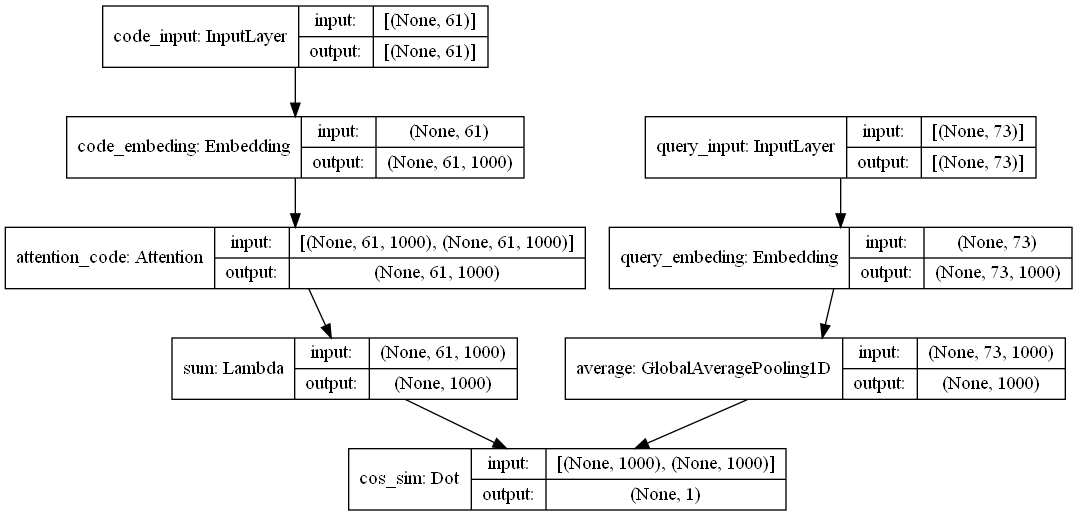

In [36]:

embedding_size = 1000

code_input = tf.keras.Input(shape=(longer_code,), name="code_input")
code_embeding = tf.keras.layers.Embedding(number_code_tokens, embedding_size, name="code_embeding")(code_input)

attention_code = tf.keras.layers.Attention(name="attention_code")([code_embeding, code_embeding])

query_input = tf.keras.Input(shape=(longer_desc,), name="query_input")
query_embeding = tf.keras.layers.Embedding(number_desc_tokens, embedding_size, name="query_embeding")(query_input)


code_output = tf.keras.layers.Lambda(lambda x: K.sum(x, axis=1), name="sum")( attention_code)
query_output = tf.keras.layers.GlobalAveragePooling1D(name="average")( query_embeding)

# This model generates code embedding
model_code = tf.keras.Model(inputs=[code_input], outputs=[code_output], name='model_code')
# This model generates description/query embedding
model_query = tf.keras.Model(inputs=[query_input], outputs=[query_output], name='model_query')

# Cosine similarity
# If normalize set to True, then the output of the dot product is the cosine proximity between the two samples.
cos_sim = tf.keras.layers.Dot(axes=1, normalize=True, name='cos_sim')([query_output, code_output]) 

# This model calculates cosine similarity between code and query pairs
cos_model = tf.keras.Model(inputs=[code_input, query_input], outputs=[cos_sim],name='sim_model')  

loss = tf.keras.layers.Flatten()(cos_sim)
training_model = tf.keras.Model(inputs=[ code_input, query_input], outputs=[cos_sim],name='training_model')

model_code.compile(loss='cosine_proximity', optimizer='adam')
model_query.compile(loss='cosine_proximity', optimizer='adam')

cos_model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=["accuracy"]) # extract similarity

# Negative sampling
good_desc_input = tf.keras.Input(shape=(longer_desc,), name="good_desc_input")
bad_desc_input = tf.keras.Input(shape=(longer_desc,), name="bad_desc_input")

good_desc_output = cos_model([code_input, good_desc_input])
bad_desc_output = cos_model([code_input, bad_desc_input])

margin = 0.9
loss = tf.keras.layers.Lambda(lambda x: K.maximum(1e-6, margin - x[0] + x[1]), output_shape=lambda x: x[0], name='loss')([good_desc_output, bad_desc_output])

training_model =  tf.keras.Model(inputs=[code_input, good_desc_input, bad_desc_input], outputs=[loss],name='training_model')

training_model.compile(loss=lambda y_true, y_pred:  y_pred+y_true-y_true, optimizer='adam') 
# y_true-y_true avoids warning

tf.keras.utils.plot_model(cos_model, "cos_model.png", show_shapes=True)

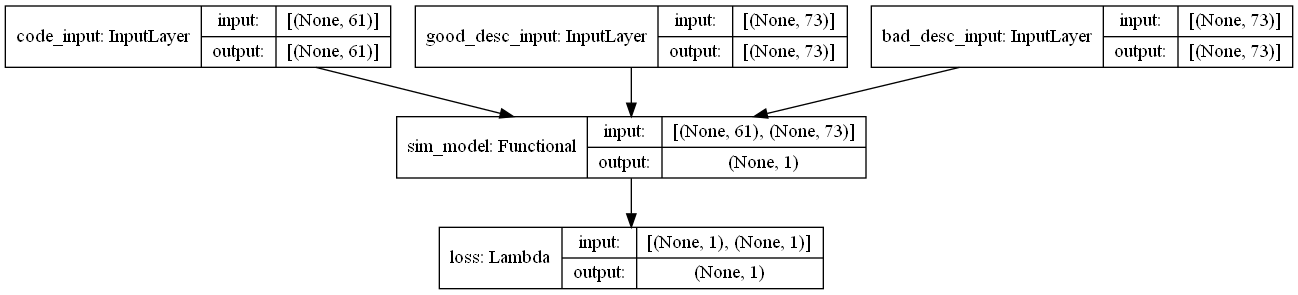

In [37]:
tf.keras.utils.plot_model(training_model, "training_model.png", show_shapes=True)

In [38]:
dumb_label = np.zeros((code_vector.shape[0], 1))
# 10000
training_code = code_vector[:8000,:]
valid_code = code_vector[8000:]

training_desc = desc_vector[:8000]
valid_desc = desc_vector[8000:]

training_bad_desc = bad_desc_vector[:8000]
valid_bad_desc = bad_desc_vector[8000:]

train_dumb_label = dumb_label[:8000]
valid_dumb_label = dumb_label[8000:]

print(training_code.shape, training_desc.shape, training_bad_desc.shape)
print(train_dumb_label.shape)

earlystop_callback = EarlyStopping(monitor='val_loss', mode='min', patience=2)
training_model.fit(x=[training_code, training_desc, training_bad_desc], y=train_dumb_label, epochs=5, verbose=1,
                    validation_data=([valid_code, valid_desc, valid_bad_desc], valid_dumb_label), callbacks=[earlystop_callback])

(8000, 61) (8000, 73) (8000, 73)
(8000, 1)
Epoch 1/5
250/250 [==============================] - 57s 224ms/step - loss: 0.9010 - val_loss: 0.9033
Epoch 2/5
250/250 [==============================] - 58s 231ms/step - loss: 0.8845 - val_loss: 0.5790
Epoch 3/5
250/250 [==============================] - 63s 251ms/step - loss: 0.3916 - val_loss: 0.4724
Epoch 4/5
250/250 [==============================] - 59s 237ms/step - loss: 0.1562 - val_loss: 0.4580
Epoch 5/5
250/250 [==============================] - 58s 232ms/step - loss: 0.0746 - val_loss: 0.4760


## Test

In [45]:
code_test_vec = []
desc_test_vec = []
bad_test_vec = []
dumb_test_label = []

if file_format == "txt":

    test_tokens_file_name = "test.tokens.txt"
    test_desc_file_name = "test.desc.txt"

    test_tokens = read_file(data_path+test_tokens_file_name).splitlines()
    test_desc = read_file(data_path+test_desc_file_name).splitlines()
    test_bad_desc = read_file(data_path+test_desc_file_name).splitlines()
    random.shuffle(test_bad_desc)

    code_test_vec = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_code.texts_to_sequences(test_tokens), padding='post')
    desc_test_vec = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(test_desc), padding='post')
    bad_test_vec = tf.keras.preprocessing.sequence.pad_sequences(tokenizer_desc.texts_to_sequences(test_bad_desc), padding='post')

    dumb_test_label = np.zeros((code_test_vec.shape[0], 1))

    print(code_test_vec.shape)
    print(desc_test_vec.shape)
else:
    test_tokens = load_hdf5( "./data/test.tokens."+file_format, 0, 100000)
    test_desc = load_hdf5( "./data/test.desc."+file_format, 0, 100000)
    test_bad_desc = load_hdf5( "./data/test.desc."+file_format, 0, 100000)
    random.shuffle(test_bad_desc)
    
    code_test_vec = pad(test_tokens, longer_code)
    desc_test_vec = pad(test_desc, longer_desc)
    bad_test_vec = pad(test_bad_desc, longer_desc)
    
    dumb_test_label = np.zeros((code_test_vec.shape[0], 1))

(10000, 61)
(10000, 73)


In [46]:
print( training_model.metrics_names)
training_model.evaluate(x=[code_test_vec, desc_test_vec, bad_test_vec], y=dumb_test_label)

['loss']
313/313 [==============================] - 8s 25ms/step - loss: 0.2965


0.29654908180236816

In [47]:
print( cos_model.metrics_names)
cos_model.evaluate(x=[code_test_vec, desc_test_vec], y=dumb_test_label)

['loss', 'accuracy']
313/313 [==============================] - 5s 17ms/step - loss: 1.1466 - accuracy: 0.2008


[1.1465691328048706, 0.20080000162124634]

In [48]:
# Similarity between code and its description
cos_model.predict( [code_test_vec[8:9,:]  , desc_test_vec[8:9,:]  ]  )

array([[0.725621]], dtype=float32)

In [49]:
# Similarity between code and a randomly picked description
cos_model.predict( [code_test_vec[7:8,:]  , desc_test_vec[90:91,:]  ]  )

array([[-0.46952125]], dtype=float32)

In [52]:
test_code = code_test_vec[0:1,:] 
test_desc = desc_test_vec[0:1,:] 

In [53]:
# get representation
code_rep = model_code.predict(test_code) 
desc_rep = model_query.predict(test_desc)

print(code_rep)
print(desc_rep)

[[ 0.17435123  0.11758168  0.09531736  0.36602744 -0.15715806 -0.156155
   0.06664582 -0.09121607 -0.24475385 -0.19083631  0.20373575 -0.42706543
   0.2706214   0.1584481   0.14331463 -0.21237758 -0.27345303  0.2553151
  -0.12196991  0.07671393  0.21540573 -0.23791602  0.24648476 -0.43821737
  -0.1743077   0.39921835 -0.07887162  0.41660547 -0.01936741  0.14815883
  -0.283033   -0.05547311  0.00367572  0.03113923 -0.05468701 -0.01623688
  -0.2547833   0.24790259 -0.25009277 -0.35506314  0.08181585  0.34722134
   0.15565357  0.14439559 -0.19971769 -0.16236137 -0.33413458  0.2390041
   0.10611634  0.23711433  0.38346097 -0.06877036  0.02912961 -0.14524655
  -0.03625428  0.5310618   0.19885631  0.00944002 -0.17417926  0.18143122
   0.35940027  0.41246083 -0.22167762 -0.25780064  0.4005591  -0.09296602
   0.19291589 -0.03328489  0.1685278   0.43583256  0.08290219 -0.13307132
   0.09003485  0.04391462 -0.11178266  0.20789884 -0.36974737  0.04730114
   0.3546534   0.15732941  0.24987306 -0.3

In [55]:
# Similarity of vectors

tf.keras.layers.Dot(axes=1, normalize=True)([code_rep, desc_rep]).numpy() # If set to True, then the output of the dot product is the cosine proximity between the two samples.

array([[0.6569808]], dtype=float32)